In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

import numpy as np
import pandas as pd

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

from thinkbayes2 import MakePoissonPmf, EvalBinomialPmf, MakeMixture

import thinkplot

import pymc3 as pm

In [6]:
import theano.tensor as tt
from pymc3.distributions import Continuous

In [ ]:
class Selected(Continuous):
    R"""
    Forked from Pymc Interpolated distribution
    Selects one of several input distributions.
    Univariate probability distribution defined as a linear interpolation
    of probability density function evaluated on some lattice of points.
    The lattice can be uneven, so the steps between different points can have
    different size and it is possible to vary the precision between regions
    of the support.
    The probability density function values don not have to be normalized, as the
    interpolated density is any way normalized to make the total probability
    equal to $1$.
    Both parameters `x_points` and values `pdf_points` are not variables, but
    plain array-like objects, so they are constant and cannot be sampled.
    ========  ===========================================
    Support   :math:`x \in [x\_points[0], x\_points[-1]]`
    ========  ===========================================
    Parameters
    ----------
    x_points : array-like
        A monotonically growing list of values
    pdf_points : array-like
        Probability density function evaluated on lattice `x_points`
    """

    def __init__(self, x_points, pdf_points, transform='interval',
                 *args, **kwargs):
        if transform == 'interval':
            transform = transforms.interval(x_points[0], x_points[-1])
        super(Interpolated, self).__init__(transform=transform,
                                           *args, **kwargs)

        interp = InterpolatedUnivariateSpline(x_points, pdf_points, k=1, ext='zeros')
        Z = interp.integral(x_points[0], x_points[-1])

        self.Z = tt.as_tensor_variable(Z)
        self.interp_op = SplineWrapper(interp)
        self.x_points = x_points
        self.pdf_points = pdf_points / Z
        self.cdf_points = interp.antiderivative()(x_points) / Z

        self.median = self._argcdf(0.5)

    def _argcdf(self, p):
        pdf = self.pdf_points
        cdf = self.cdf_points
        x = self.x_points

        index = np.searchsorted(cdf, p) - 1
        slope = (pdf[index + 1] - pdf[index]) / (x[index + 1] - x[index])

        return x[index] + np.where(
            np.abs(slope) <= 1e-8,
            np.where(
                np.abs(pdf[index]) <= 1e-8,
                np.zeros(index.shape),
                (p - cdf[index]) / pdf[index]
            ),
            (-pdf[index] + np.sqrt(pdf[index] ** 2 + 2 * slope * (p - cdf[index]))) / slope
        )

    def _random(self, size=None):
        return self._argcdf(np.random.uniform(size=size))

    def random(self, point=None, size=None, repeat=None):
        return generate_samples(self._random,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        return tt.log(self.interp_op(value) / self.Z)

In [21]:
# Sample Bimodal model
data = np.concatenate([np.random.normal(0, 1, 1000), np.random.normal(5, 1, 200)])

with pm.Model() as model:
    mus = pm.Normal('mus', 0, 10, shape=(2))
    val1 = pm.ElemwiseCategorical()

{'xscale': 'linear', 'yscale': 'linear'}

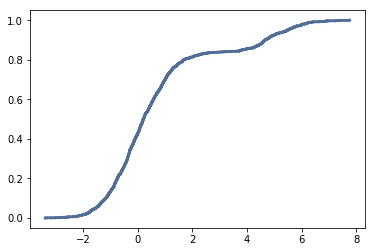

In [19]:
thinkplot.Cdf(Cdf(data))

In [32]:
scenarios

['ltbcre', 'ltbcr', 'ltbce', 'ltbc', 'ltbre', 'ltbr', 'ltbe', 'ltb']

In [30]:
from itertools import product
scenarios = list(product('l', 't', 'b', 'c ', 'r ', 'e '))
scenarios = [''.join([e for e in scen if e != ' ']) for scen in scenarios]

with pm.Model() as model:
    scenario_id = pm.Categorical('scenario_id', p=[1]*len(scenarios))
    species_present = pm.Binomial('species_present', n=1, p=0.5, shape=(6,))
    
    scenario_rvs = [pm.Dirichlet(s, a=np.array([1]*len(s))) for s in scenarios]
    scenario_rvs = tt.as_tensor_variable(scenario_rvs)
    
    scenario_rvs[scenario_id]

    concentrations = pm.Dirichlet('concentrations', a=np.array((1,1,1,1,1,1)))

AsTensorError: ('Cannot convert [ltbcre, ltbcr, ltbce, ltbc, ltbre, ltbr, ltbe, ltb] to TensorType', <class 'list'>)

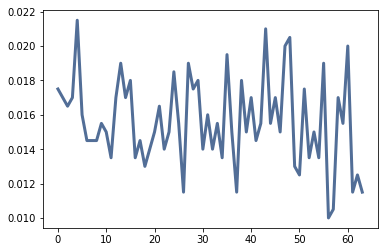

In [14]:
with model:
    trace_prior = pm.sample_prior_predictive(2000)

prior_species = Joint(map(tuple, trace_prior['species_present']))
thinkplot.Plot(prior_species.GetDict().values())

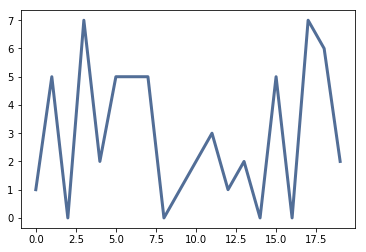

In [16]:
thinkplot.Plot(trace_prior['scenario_id'][:20])

In [4]:
trace_prior['concentrations']

array([[0.10626501, 0.08669489, 0.03902688, 0.10770508, 0.56257692,
        0.09773122],
       [0.00726195, 0.09718944, 0.17001439, 0.02719954, 0.4921804 ,
        0.20615429],
       [0.02056996, 0.0020457 , 0.39539469, 0.05295663, 0.33499196,
        0.19404107],
       ...,
       [0.12818541, 0.46462607, 0.03069758, 0.0277675 , 0.07177587,
        0.27694757],
       [0.23477973, 0.10239829, 0.19879946, 0.0512291 , 0.39563494,
        0.01715849],
       [0.23565911, 0.10923449, 0.10883474, 0.37994203, 0.10173661,
        0.06459301]])